# Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:
- Customer details ('Gender', 'Age', 'Region_Code' etc.)
- Details of his/her relationship with the bank ('Channel_Code', 'Vintage', 'Avg_Account_Balance' etc.)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
train_df.shape, test_df.shape

((245725, 11), (105312, 10))

In [4]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [5]:
test_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


## Exploratory Data Analysis

In [6]:
#Performing EDA using pandas_profiling
profile = ProfileReport(train_df, title="Exploratory Data Analysis", explorative=True)
profile

In [7]:
#Exporting the generated report as a html file
profile.to_file(output_file='Exploratory_Data_Analysis.html')

## Combining Train and Test dataset

In [8]:
train_df['source'] = 'train'
test_df['source'] = 'test'
data = pd.concat([train_df, test_df], ignore_index=True)

In [9]:
data.shape

(351037, 12)

In [10]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,source
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,train


## Data Preprocessing

In [11]:
#Checking missing values
data.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
source                      0
dtype: int64

In [12]:
#Checking data types
data.dtypes

ID                      object
Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance      int64
Is_Active               object
Is_Lead                float64
source                  object
dtype: object

In [13]:
#Number of distinct observations
data.nunique()

ID                     351037
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    162137
Is_Active                   2
Is_Lead                     2
source                      2
dtype: int64

In [14]:
data['Credit_Product'].value_counts()

No     205965
Yes    103225
Name: Credit_Product, dtype: int64

In [15]:
#Replacing nan with new category NA
data['Credit_Product'].replace(np.nan,'NA',inplace=True) 

In [16]:
#Log transformation to make data follow normal distribution as ideally bank balance/salary will follow log-normal
data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance'])

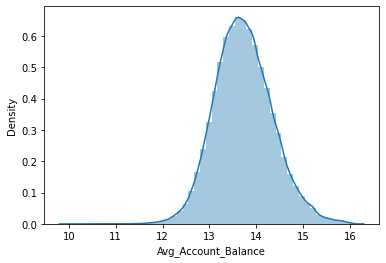

In [17]:
sns.distplot(data['Avg_Account_Balance'])
plt.show()

## Label Encoding

In [18]:
le = LabelEncoder()
var_mod = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [19]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,source
0,NNVBBKZB,0,73,18,1,2,43,1,13.860193,0,0.0,train
1,IDD62UNG,0,30,27,2,0,32,1,13.274205,0,0.0,train
2,HD3DSEMC,0,56,18,3,2,26,1,14.210464,1,0.0,train
3,BF3NC7KV,1,34,20,2,0,19,1,13.061453,0,0.0,train
4,TEASRWXV,0,30,32,2,0,33,1,13.695360,0,0.0,train


## Separating Train and Test dataset

In [20]:
train_df = data.loc[data['source']=="train"]
test_df = data.loc[data['source']=="test"]

#Drop unnecessary columns:
train_df.drop(['ID', 'source'], axis=1, inplace=True)
test_df.drop(['ID', 'Is_Lead', 'source'], axis=1, inplace=True)

In [21]:
train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,18,1,2,43,1,13.860193,0,0.0
1,0,30,27,2,0,32,1,13.274205,0,0.0
2,0,56,18,3,2,26,1,14.210464,1,0.0
3,1,34,20,2,0,19,1,13.061453,0,0.0
4,0,30,32,2,0,33,1,13.695360,0,0.0


In [22]:
train_df['Is_Lead'].value_counts()

0.0    187437
1.0     58288
Name: Is_Lead, dtype: int64

In [23]:
X = train_df.drop('Is_Lead',axis=1)
y = train_df['Is_Lead']

## Feature Importance

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train_df.iloc[:,0:9] #Independent columns 
y = train_df.iloc[:,-1] #Target column i.e Is_Lead   

#Apply SelectKBest class to extract top 9 best features
bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Column','Score'] #Naming the dataframe columns
print(featureScores.nlargest(9,'Score')) #Print 9 best features

                Column          Score
5              Vintage  428316.970019
1                  Age   65636.213237
4         Channel_Code   14539.106549
2          Region_Code    5703.671209
6       Credit_Product    2954.689767
8            Is_Active    1104.406107
0               Gender     579.252616
7  Avg_Account_Balance      36.915915
3           Occupation      13.125378


[0.00694274 0.1456871  0.10293923 0.03306059 0.0448589  0.15237712
 0.28967276 0.21347208 0.01098948]


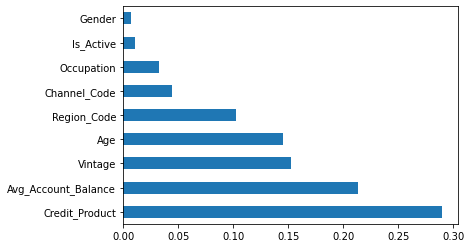

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X, y)

#Use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_) 

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

## Training and Validation Splitting

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=22)

## Model Evaluation

Checking ROC AUC Score for default models

In [27]:
names = [
    "LightGBM",
    "XGBoost",
    "CatBoost"
]

classifiers = [
    LGBMClassifier(),
    XGBClassifier(eval_metric='logloss'),
    CatBoostClassifier()
]

In [28]:
sub_model_dict = {}    
for name, clf in zip(names, classifiers):
    #Training
    clf.fit(X_train, y_train)
    #Prediction on Validation Set
    y_pred = clf.predict_proba(X_val)[:,1]
    #ROC AUC Score
    roc_score = roc_auc_score(y_val, y_pred)
    print("{0} - {1}".format(name, roc_score))
    sub_model_dict[name] = [roc_score]

LightGBM - 0.8739032752550357
XGBoost - 0.8719177604044319
Learning rate set to 0.095567
0:	learn: 0.6197807	total: 295ms	remaining: 4m 55s
1:	learn: 0.5623126	total: 389ms	remaining: 3m 14s
2:	learn: 0.5186752	total: 476ms	remaining: 2m 38s
3:	learn: 0.4843559	total: 553ms	remaining: 2m 17s
4:	learn: 0.4577613	total: 620ms	remaining: 2m 3s
5:	learn: 0.4378319	total: 685ms	remaining: 1m 53s
6:	learn: 0.4223652	total: 761ms	remaining: 1m 48s
7:	learn: 0.4089056	total: 824ms	remaining: 1m 42s
8:	learn: 0.3989070	total: 888ms	remaining: 1m 37s
9:	learn: 0.3902498	total: 969ms	remaining: 1m 35s
10:	learn: 0.3838483	total: 1.03s	remaining: 1m 32s
11:	learn: 0.3755680	total: 1.09s	remaining: 1m 29s
12:	learn: 0.3715862	total: 1.17s	remaining: 1m 28s
13:	learn: 0.3682125	total: 1.23s	remaining: 1m 26s
14:	learn: 0.3655925	total: 1.29s	remaining: 1m 24s
15:	learn: 0.3634852	total: 1.37s	remaining: 1m 24s
16:	learn: 0.3624771	total: 1.42s	remaining: 1m 21s
17:	learn: 0.3608846	total: 1.48s	rema

158:	learn: 0.3407187	total: 11.5s	remaining: 1m
159:	learn: 0.3406890	total: 11.6s	remaining: 1m
160:	learn: 0.3406632	total: 11.6s	remaining: 1m
161:	learn: 0.3406342	total: 11.7s	remaining: 1m
162:	learn: 0.3406054	total: 11.8s	remaining: 1m
163:	learn: 0.3405790	total: 11.8s	remaining: 1m
164:	learn: 0.3405449	total: 11.9s	remaining: 1m
165:	learn: 0.3405205	total: 12s	remaining: 1m
166:	learn: 0.3405016	total: 12s	remaining: 60s
167:	learn: 0.3404702	total: 12.1s	remaining: 59.9s
168:	learn: 0.3404475	total: 12.2s	remaining: 59.8s
169:	learn: 0.3404241	total: 12.2s	remaining: 59.8s
170:	learn: 0.3403922	total: 12.3s	remaining: 59.7s
171:	learn: 0.3403640	total: 12.4s	remaining: 59.6s
172:	learn: 0.3403406	total: 12.4s	remaining: 59.4s
173:	learn: 0.3403115	total: 12.5s	remaining: 59.4s
174:	learn: 0.3402838	total: 12.6s	remaining: 59.3s
175:	learn: 0.3402054	total: 12.6s	remaining: 59.2s
176:	learn: 0.3401815	total: 12.7s	remaining: 59.1s
177:	learn: 0.3401549	total: 12.8s	remaini

320:	learn: 0.3366505	total: 22.2s	remaining: 47s
321:	learn: 0.3366306	total: 22.3s	remaining: 46.9s
322:	learn: 0.3366105	total: 22.3s	remaining: 46.8s
323:	learn: 0.3365865	total: 22.4s	remaining: 46.7s
324:	learn: 0.3365606	total: 22.4s	remaining: 46.6s
325:	learn: 0.3365471	total: 22.5s	remaining: 46.6s
326:	learn: 0.3365227	total: 22.6s	remaining: 46.5s
327:	learn: 0.3365042	total: 22.7s	remaining: 46.4s
328:	learn: 0.3364829	total: 22.7s	remaining: 46.3s
329:	learn: 0.3364651	total: 22.8s	remaining: 46.3s
330:	learn: 0.3364443	total: 22.9s	remaining: 46.2s
331:	learn: 0.3364142	total: 22.9s	remaining: 46.1s
332:	learn: 0.3363861	total: 23s	remaining: 46s
333:	learn: 0.3363665	total: 23s	remaining: 46s
334:	learn: 0.3363463	total: 23.1s	remaining: 45.9s
335:	learn: 0.3363220	total: 23.2s	remaining: 45.8s
336:	learn: 0.3363055	total: 23.2s	remaining: 45.7s
337:	learn: 0.3362796	total: 23.3s	remaining: 45.7s
338:	learn: 0.3362467	total: 23.4s	remaining: 45.6s
339:	learn: 0.3362281	

481:	learn: 0.3332462	total: 33.2s	remaining: 35.7s
482:	learn: 0.3332231	total: 33.2s	remaining: 35.6s
483:	learn: 0.3332027	total: 33.3s	remaining: 35.5s
484:	learn: 0.3331899	total: 33.4s	remaining: 35.5s
485:	learn: 0.3331697	total: 33.5s	remaining: 35.4s
486:	learn: 0.3331560	total: 33.5s	remaining: 35.3s
487:	learn: 0.3331342	total: 33.6s	remaining: 35.3s
488:	learn: 0.3331132	total: 33.7s	remaining: 35.2s
489:	learn: 0.3330859	total: 33.8s	remaining: 35.2s
490:	learn: 0.3330641	total: 33.9s	remaining: 35.1s
491:	learn: 0.3330473	total: 33.9s	remaining: 35s
492:	learn: 0.3330219	total: 34s	remaining: 35s
493:	learn: 0.3330085	total: 34.1s	remaining: 34.9s
494:	learn: 0.3329934	total: 34.2s	remaining: 34.9s
495:	learn: 0.3329821	total: 34.2s	remaining: 34.8s
496:	learn: 0.3329606	total: 34.3s	remaining: 34.7s
497:	learn: 0.3329377	total: 34.4s	remaining: 34.7s
498:	learn: 0.3329196	total: 34.5s	remaining: 34.6s
499:	learn: 0.3328987	total: 34.5s	remaining: 34.5s
500:	learn: 0.3328

641:	learn: 0.3301918	total: 44.2s	remaining: 24.6s
642:	learn: 0.3301759	total: 44.2s	remaining: 24.6s
643:	learn: 0.3301530	total: 44.3s	remaining: 24.5s
644:	learn: 0.3301347	total: 44.4s	remaining: 24.4s
645:	learn: 0.3301138	total: 44.4s	remaining: 24.3s
646:	learn: 0.3300959	total: 44.5s	remaining: 24.3s
647:	learn: 0.3300793	total: 44.6s	remaining: 24.2s
648:	learn: 0.3300556	total: 44.6s	remaining: 24.1s
649:	learn: 0.3300335	total: 44.7s	remaining: 24.1s
650:	learn: 0.3300181	total: 44.8s	remaining: 24s
651:	learn: 0.3300019	total: 44.8s	remaining: 23.9s
652:	learn: 0.3299787	total: 44.9s	remaining: 23.9s
653:	learn: 0.3299574	total: 45s	remaining: 23.8s
654:	learn: 0.3299344	total: 45s	remaining: 23.7s
655:	learn: 0.3299177	total: 45.1s	remaining: 23.6s
656:	learn: 0.3299081	total: 45.2s	remaining: 23.6s
657:	learn: 0.3298937	total: 45.2s	remaining: 23.5s
658:	learn: 0.3298769	total: 45.3s	remaining: 23.4s
659:	learn: 0.3298623	total: 45.4s	remaining: 23.4s
660:	learn: 0.3298

802:	learn: 0.3273964	total: 54.9s	remaining: 13.5s
803:	learn: 0.3273792	total: 55s	remaining: 13.4s
804:	learn: 0.3273665	total: 55s	remaining: 13.3s
805:	learn: 0.3273467	total: 55.1s	remaining: 13.3s
806:	learn: 0.3273287	total: 55.1s	remaining: 13.2s
807:	learn: 0.3273074	total: 55.2s	remaining: 13.1s
808:	learn: 0.3272935	total: 55.3s	remaining: 13.1s
809:	learn: 0.3272783	total: 55.4s	remaining: 13s
810:	learn: 0.3272665	total: 55.4s	remaining: 12.9s
811:	learn: 0.3272476	total: 55.5s	remaining: 12.8s
812:	learn: 0.3272396	total: 55.6s	remaining: 12.8s
813:	learn: 0.3272264	total: 55.6s	remaining: 12.7s
814:	learn: 0.3272072	total: 55.7s	remaining: 12.6s
815:	learn: 0.3271882	total: 55.8s	remaining: 12.6s
816:	learn: 0.3271714	total: 55.8s	remaining: 12.5s
817:	learn: 0.3271530	total: 55.9s	remaining: 12.4s
818:	learn: 0.3271417	total: 56s	remaining: 12.4s
819:	learn: 0.3271135	total: 56s	remaining: 12.3s
820:	learn: 0.3270966	total: 56.1s	remaining: 12.2s
821:	learn: 0.3270713	

962:	learn: 0.3247206	total: 1m 5s	remaining: 2.53s
963:	learn: 0.3247003	total: 1m 5s	remaining: 2.46s
964:	learn: 0.3246863	total: 1m 5s	remaining: 2.39s
965:	learn: 0.3246705	total: 1m 5s	remaining: 2.32s
966:	learn: 0.3246554	total: 1m 6s	remaining: 2.25s
967:	learn: 0.3246387	total: 1m 6s	remaining: 2.18s
968:	learn: 0.3246286	total: 1m 6s	remaining: 2.12s
969:	learn: 0.3246179	total: 1m 6s	remaining: 2.05s
970:	learn: 0.3246009	total: 1m 6s	remaining: 1.98s
971:	learn: 0.3245897	total: 1m 6s	remaining: 1.91s
972:	learn: 0.3245741	total: 1m 6s	remaining: 1.84s
973:	learn: 0.3245578	total: 1m 6s	remaining: 1.77s
974:	learn: 0.3245409	total: 1m 6s	remaining: 1.71s
975:	learn: 0.3245264	total: 1m 6s	remaining: 1.64s
976:	learn: 0.3245094	total: 1m 6s	remaining: 1.57s
977:	learn: 0.3244942	total: 1m 6s	remaining: 1.5s
978:	learn: 0.3244766	total: 1m 6s	remaining: 1.43s
979:	learn: 0.3244619	total: 1m 6s	remaining: 1.36s
980:	learn: 0.3244454	total: 1m 6s	remaining: 1.3s
981:	learn: 0.

In [29]:
model_variable = pd.DataFrame(sub_model_dict, index = ['ROC AUC Score']).T
model_variable = model_variable.sort_values(by=['ROC AUC Score'], ascending=False)
model_variable

,ROC AUC Score
LightGBM,0.873903
CatBoost,0.872622
XGBoost,0.871918


## Hyperparameter Optimization

Cross-Validation function using Stratified K-Fold

In [30]:
#StratifiedKFold is chosen, since target label is unbalanced
def cross_val(X, y, model, params, folds=9):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=22)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-" * 50)

    return alg

## LightGBM Classifier

In [31]:
#Finding Best Parameters using RandomizedSearchCV
lgb_params = {
     'num_leaves': range(6, 50), 
     'min_child_samples': range(100, 500), 
     'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
     'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
     'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
     'boosting_type' : ['gbdt','dart','goss','rf'],
     'learning_rate': [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.38, 0.40],
}
lgb_model = LGBMClassifier()
cv_model_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=lgb_params,
                                   scoring='roc_auc', n_jobs=-1, return_train_score=True)
cv_model_lgb.fit(X_train, y_train)
cv_model_lgb.best_params_

{'reg_lambda': 50,
 'reg_alpha': 0,
 'num_leaves': 16,
 'min_child_weight': 1,
 'min_child_samples': 332,
 'learning_rate': 0.25,
 'boosting_type': 'dart'}

In [32]:
#Fine Tuning LightGBM using Best Parameters and Cross-Validation function
lgb_params = {'reg_lambda': 50,
              'reg_alpha': 0,
              'num_leaves': 16,
              'min_child_weight': 1,
              'min_child_samples': 332,
              'learning_rate': 0.25,
              'boosting_type': 'dart',
              'n_jobs': -1}
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
roc_auc_score: 0.8734277332724221
--------------------------------------------------
Fold: 1
roc_auc_score: 0.8771681526329156
--------------------------------------------------
Fold: 2
roc_auc_score: 0.8705029244270122
--------------------------------------------------
Fold: 3
roc_auc_score: 0.8728768904607177
--------------------------------------------------
Fold: 4
roc_auc_score: 0.8743832660036583
--------------------------------------------------
Fold: 5
roc_auc_score: 0.8740608032610157
--------------------------------------------------
Fold: 6
roc_auc_score: 0.8777102916789934
--------------------------------------------------
Fold: 7
roc_auc_score: 0.8729939634242297
--------------------------------------------------
Fold: 8
roc_auc_score: 0.8745673029098954
--------------------------------------------------


## XGBoost Classifier

In [33]:
#Finding Best Parameters using RandomizedSearchCV
xgb_params = {
     'n_estimators': [5, 10, 50, 100, 150, 200, 300, 500, 750, 800, 900, 1000],
     'max_depth': range(3, 10, 2),
     'min_child_weight': range(1, 6, 2),
     'gamma': [i/10.0 for i in range(0, 5)],
     'colsample_bytree': [i/10.0 for i in range(6, 10)]
}
xgb_model = XGBClassifier(eval_metric='logloss')
cv_model_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params,
                                   scoring='roc_auc', n_jobs=-1, return_train_score=True)
cv_model_xgb.fit(X_train, y_train)
cv_model_xgb.best_params_

{'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 3,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [34]:
#Fine Tuning XGBoost using Best Parameters and Cross-Validation function
xgb_params = {'n_estimators': 300,
              'min_child_weight': 5,
              'max_depth': 3,
              'gamma': 0.0,
              'colsample_bytree': 0.7,
              'eval_metric': 'logloss',
              'n_jobs': -1}
xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

Fold: 0
[0]	validation_0-logloss:0.55490
[256]	validation_0-logloss:0.34602
roc_auc_score: 0.8723763203754522
--------------------------------------------------
Fold: 1
[0]	validation_0-logloss:0.55301
[299]	validation_0-logloss:0.34001
roc_auc_score: 0.8767009667541773
--------------------------------------------------
Fold: 2
[0]	validation_0-logloss:0.55519
[245]	validation_0-logloss:0.34947
roc_auc_score: 0.8693172508259682
--------------------------------------------------
Fold: 3
[0]	validation_0-logloss:0.55498
[283]	validation_0-logloss:0.34729
roc_auc_score: 0.8720505690258646
--------------------------------------------------
Fold: 4
[0]	validation_0-logloss:0.55510
[299]	validation_0-logloss:0.34665
roc_auc_score: 0.8737352528173288
--------------------------------------------------
Fold: 5
[0]	validation_0-logloss:0.55487
[268]	validation_0-logloss:0.34505
roc_auc_score: 0.8734126936998637
--------------------------------------------------
Fold: 6
[0]	validation_0-logloss:0

## CatBoost Classifier

In [35]:
#Finding Best Parameters using RandomizedSearchCV
cat_params = {
     'colsample_bylevel': [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50],
     'n_estimators': [5, 10, 50, 100, 150, 200, 500, 750, 1000],
     'depth': [4, 7, 10],
     'learning_rate' : [0.03, 0.1, 0.15],
     'l2_leaf_reg': [1, 4, 9],     
}
cat_model = CatBoostClassifier()
cv_model_cat = RandomizedSearchCV(estimator=cat_model, param_distributions=cat_params,
                                   scoring='roc_auc', n_jobs=-1, return_train_score=True)
cv_model_cat.fit(X_train, y_train)
cv_model_cat.best_params_

0:	learn: 0.5829554	total: 69.5ms	remaining: 13.8s
1:	learn: 0.5039304	total: 221ms	remaining: 21.9s
2:	learn: 0.4579039	total: 294ms	remaining: 19.3s
3:	learn: 0.4242478	total: 451ms	remaining: 22.1s
4:	learn: 0.4022046	total: 605ms	remaining: 23.6s
5:	learn: 0.3882748	total: 727ms	remaining: 23.5s
6:	learn: 0.3780595	total: 873ms	remaining: 24.1s
7:	learn: 0.3713574	total: 936ms	remaining: 22.5s
8:	learn: 0.3631984	total: 1.07s	remaining: 22.7s
9:	learn: 0.3580111	total: 1.22s	remaining: 23.1s
10:	learn: 0.3543588	total: 1.35s	remaining: 23.2s
11:	learn: 0.3521683	total: 1.5s	remaining: 23.5s
12:	learn: 0.3505279	total: 1.64s	remaining: 23.5s
13:	learn: 0.3499740	total: 1.68s	remaining: 22.4s
14:	learn: 0.3479656	total: 1.82s	remaining: 22.4s
15:	learn: 0.3473210	total: 1.91s	remaining: 22s
16:	learn: 0.3458141	total: 2.04s	remaining: 21.9s
17:	learn: 0.3456273	total: 2.11s	remaining: 21.3s
18:	learn: 0.3449869	total: 2.26s	remaining: 21.5s
19:	learn: 0.3444429	total: 2.41s	remaining

162:	learn: 0.3183614	total: 25.5s	remaining: 5.78s
163:	learn: 0.3182452	total: 25.6s	remaining: 5.62s
164:	learn: 0.3180780	total: 25.7s	remaining: 5.46s
165:	learn: 0.3180023	total: 25.9s	remaining: 5.3s
166:	learn: 0.3179298	total: 26s	remaining: 5.14s
167:	learn: 0.3177967	total: 26.1s	remaining: 4.98s
168:	learn: 0.3177025	total: 26.3s	remaining: 4.82s
169:	learn: 0.3175046	total: 26.4s	remaining: 4.66s
170:	learn: 0.3173250	total: 26.6s	remaining: 4.51s
171:	learn: 0.3171627	total: 26.7s	remaining: 4.35s
172:	learn: 0.3170283	total: 26.9s	remaining: 4.19s
173:	learn: 0.3168112	total: 27s	remaining: 4.04s
174:	learn: 0.3166965	total: 27.1s	remaining: 3.88s
175:	learn: 0.3165511	total: 27.3s	remaining: 3.72s
176:	learn: 0.3164477	total: 27.4s	remaining: 3.56s
177:	learn: 0.3163709	total: 27.6s	remaining: 3.41s
178:	learn: 0.3162629	total: 27.7s	remaining: 3.25s
179:	learn: 0.3161660	total: 27.8s	remaining: 3.09s
180:	learn: 0.3160253	total: 28s	remaining: 2.94s
181:	learn: 0.31585

{'n_estimators': 200,
 'learning_rate': 0.15,
 'l2_leaf_reg': 9,
 'depth': 10,
 'colsample_bylevel': 0.5}

In [36]:
#Fine Tuning CatBoost using Best Parameters and Cross-Validation function
cat_params = {'n_estimators': 200,
              'learning_rate': 0.15,
              'l2_leaf_reg': 9,
              'depth': 10,
              'colsample_bylevel': 0.5}
cat_model = cross_val(X, y, CatBoostClassifier, cat_params)

Fold: 0
0:	learn: 0.5771755	test: 0.5774069	best: 0.5774069 (0)	total: 236ms	remaining: 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3458370928
bestIteration = 42

Shrink model to first 43 iterations.
roc_auc_score: 0.872317080624752
--------------------------------------------------
Fold: 1
0:	learn: 0.5773494	test: 0.5764006	best: 0.5764006 (0)	total: 128ms	remaining: 25.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3400488644
bestIteration = 50

Shrink model to first 51 iterations.
roc_auc_score: 0.8767118471464368
--------------------------------------------------
Fold: 2
0:	learn: 0.5769907	test: 0.5777631	best: 0.5777631 (0)	total: 128ms	remaining: 25.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3484995077
bestIteration = 43

Shrink model to first 44 iterations.
roc_auc_score: 0.8691563359411971
--------------------------------------------------
Fold: 3
0:	learn: 0.5770979	test: 0.5777420	best: 0.577

## Blending Predictions

In [37]:
pred_test_lgb = lgb_model.predict_proba(test_df)[:,1]
pred_test_xgb = xgb_model.predict_proba(test_df)[:,1]
pred_test_cat = cat_model.predict_proba(test_df)[:,1]
combined_preds = pd.DataFrame({'lgb': pred_test_lgb , 'xgb': pred_test_xgb, 'cat': pred_test_cat})

In [38]:
combined_preds['avg'] = (combined_preds['xgb'] + combined_preds['lgb'] + combined_preds['cat']) / 3
combined_preds.head()

,lgb,xgb,cat,avg
0,0.055750,0.052572,0.045945,0.051422
1,0.866266,0.841781,0.858919,0.855655
2,0.055930,0.098377,0.051924,0.068744
3,0.025838,0.026980,0.025801,0.026206
4,0.026023,0.029245,0.021227,0.025498


In [39]:
sample_submission = pd.read_csv('./sample_submission.csv')

In [40]:
#sample_submission['Is_Lead'] = pred_test_lgb
#sample_submission.to_csv(f'pred_test_lgb.csv',index=False)

#sample_submission['Is_Lead'] = pred_test_xgb
#sample_submission.to_csv(f'pred_test_xgb.csv',index=False)

#sample_submission['Is_Lead'] = pred_test_cat
#sample_submission.to_csv(f'pred_test_cat.csv',index=False)

## Final Submission

In [41]:
sample_submission['Is_Lead'] = combined_preds['avg']
sample_submission.to_csv(f'final_submission.csv', index=False)